In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/scratch/fivanovic/Work/X-SH/eigenstate_plotting')
import XSH_eigenstates_Filip as XSF

In [2]:
trajH_path = '/scratch/fivanovic/X-SH/T6-PDI/production_runs/physical_system_optical/trajectory_hamiltonians'

In [3]:
def average_binned_populations(binned_eigenvecs, donor_list, acceptor_list, exciton_states, y_molecules):
    '''
    function that will take the binned matrices of eigenvectors, calculate the XT and CT populations of each
    eigenvector, then average the populations for each bin of eigenvectors
    '''

    number_bins = len(binned_eigenvecs)
    x_donors = len(donor_list)//y_molecules
    x_acceptors = len(acceptor_list)//y_molecules
    x_excitons = len(exciton_states)//y_molecules

    donor_avg_population_array = np.zeros((number_bins, x_donors))
    acceptor_avg_population_array = np.zeros((number_bins, x_acceptors))
    exciton_avg_population_array = np.zeros((number_bins, x_excitons))

    for index in range(len(binned_eigenvecs)):

        matrix_transpose = binned_eigenvecs[index].T

        donor_population_array = np.zeros((len(matrix_transpose), x_donors))
        acceptor_population_array = np.zeros((len(matrix_transpose), x_acceptors))
        exciton_population_array = np.zeros((len(matrix_transpose), x_excitons))

        for index2 in range(len(matrix_transpose)):

            donor_populations, acceptor_populations = XSF.CT_site_populations(matrix_transpose[index2], donor_list, acceptor_list)
            exciton_populations = XSF.XT_site_populations(matrix_transpose[index2], exciton_states)

            integrated_donors, integrated_acceptors = XSF.integrated_CT_populations(donor_populations, acceptor_populations, y_molecules)
            integrated_excitons = XSF.integrated_XT_populations(exciton_populations, y_molecules)

            donor_population_array[index2,:] = integrated_donors
            acceptor_population_array[index2,:] = integrated_acceptors
            exciton_population_array[index2,:] = integrated_excitons
        
        donor_population_average = np.mean(donor_population_array, axis=0)
        acceptor_population_average = np.mean(acceptor_population_array, axis=0)
        exciton_population_average = np.mean(exciton_population_array, axis=0)

        donor_avg_population_array[index,:] = donor_population_average
        acceptor_avg_population_array[index,:] = acceptor_population_average
        exciton_avg_population_array[index,:] = exciton_population_average

    return donor_avg_population_array, acceptor_avg_population_array, exciton_avg_population_array

In [4]:
def build_sim_H(H_input, dimension):
    '''
    function transcribes hamiltonian elements read in from run-pseudo-hamilt.xyz file into a corresponding numpy array

    inputs: H_input = list of lists, each element of lists is a string containing an element's magnitude and position in 
    the Hamiltonian, dimension = number of rows/columns in H matrix

    output: 2D numpy array representing electronic Hamiltonian
    '''
    
    hamiltonian = np.zeros((dimension, dimension))

    for element in H_input:

        row = int(element[0]) - 1
        column = int(element[1]) - 1
        quantity = float(element[2])

        if row == column:
            quantity = quantity/2

        hamiltonian[row, column] = quantity
    
    lowest_site_energy = min(np.diag(hamiltonian))
    hamiltonian = hamiltonian - np.identity(len(hamiltonian))*lowest_site_energy

    hamiltonian = hamiltonian + hamiltonian.T
    
    return hamiltonian

In [7]:
#print_times_fs = [time for time in range(0,110,10)] + [time for time in range(2195,2250,10)] + [time for time in range(4375,4485,10)]
print_times_fs = [time for time in range(4375,4485,10)]

active_states = np.loadtxt(trajH_path + '/traj0/physopt-traj0-active-states.txt')

dons = [d for d in range(0,20)]
accs = [a for a in range(20,40)]

for print_time in print_times_fs:

    printed_H = np.loadtxt(trajH_path + f'/traj0/physopt-H-trajectory0-{print_time}.0fs')
    H = build_sim_H(printed_H, 420)

    eigenvals, eigenvecs = XSF.get_eigen(H)
    eigenvals = eigenvals*27200

    active_state = int(active_states[print_time*2]) - 1
    active_state_energy = eigenvals[active_state]

    binned_eigenvals, binned_eigenvecs, used_energy_bins = XSF.bin_eigenspectrum(eigenvals, eigenvecs, 25)
    average_dpops, average_apops, average_exc_pops = average_binned_populations(binned_eigenvecs, dons, accs, accs, 1)

    #switching rows of populations around as the averaging scripts assume that the donor/acceptor indices are in order of increasing distance,
    #but in the DECOMP file used for this Hamiltonian, some molecules with higher indices have lower x-displacement

    #average_dpops[:, [-1,-2]] = average_dpops[:, [-2,-1]]
    #average_dpops[:, [-3,-4]] = average_dpops[:, [-4,-3]]
    #average_dpops[:, [-5,-6]] = average_dpops[:, [-6,-5]]

    average_dpops[:, [0,1]] = average_dpops[:, [1,0]]
    #average_dpops[:, [2,3]] = average_dpops[:, [3,2]]
    #average_dpops[:, [4,5]] = average_dpops[:, [5,4]]

    fig, axes = XSF.plot_eigenspectrum(average_dpops, average_apops, average_exc_pops, figure_size=(12,13), max_shading=0.3, exciton_radius=400, bins=used_energy_bins, active_state_energy=active_state_energy, binned_eigenvals=binned_eigenvals)
    plt.subplots_adjust(wspace = 0, hspace = 0, bottom=0.05, top=0.95)
    fig.supylabel('Binned eigenstate energy /meV')
    fig.suptitle(f'Eigenstate Scheme - {print_time}fs')

    plt.savefig(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/physical_system_optical/trajectory_hamiltonians/traj0/eigenstate-scheme-{print_time}fs.png')
    plt.close()
    

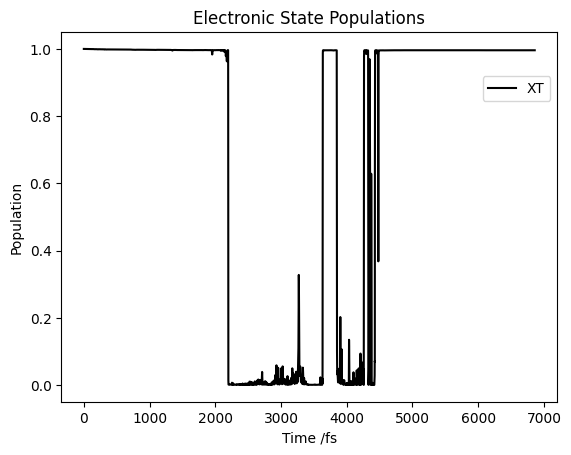

In [6]:
#loading in arrays which have the time-dependent populations of different diabat types, for each individual trajectory

total_XT_single_populations = np.loadtxt(trajH_path + '/traj0/physopt_XT_individual_populations-traj0.txt')

CSS_single_populations = np.loadtxt(trajH_path + '/traj0/physopt_CSS_individual_populations-traj0.txt')
INT_single_populations = np.loadtxt(trajH_path + '/traj0/physopt_INT_individual_populations-traj0.txt')
A_INT_single_populations = np.loadtxt(trajH_path + '/traj0/physopt_A_INT_individual_populations-traj0.txt')

CT_single_populations = 1 - INT_single_populations - A_INT_single_populations - total_XT_single_populations - CSS_single_populations
total_population = CSS_single_populations + A_INT_single_populations + INT_single_populations + total_XT_single_populations
#CT_single_populations corresponds to CT-states that are neither interfacial nor charge-separated
#the total is therefore all of the CT-states' populations put together

nuclear_timestep = 0.05
time_nstep_intervals = np.arange(0, len(INT_single_populations))*nuclear_timestep*10

#plt.plot(time_nstep_intervals, INT_single_populations, color = 'r', label = 'Interfacial CT')
#plt.plot(time_nstep_intervals, A_INT_single_populations, color = 'm', label = 'Near-interfacial CT')
#plt.plot(time_nstep_intervals, total_population, color = 'g', label = 'Non-interfacial CT')
#plt.plot(time_nstep_intervals, CSS_single_populations, color = 'b', label = 'CSS')
plt.plot(time_nstep_intervals, total_XT_single_populations, color = 'k', label = 'XT')
plt.ylabel('Population')
plt.xlabel('Time /fs')
plt.title('Electronic State Populations')
plt.legend(bbox_to_anchor = (1.0, 0.9))